In [2]:
import numpy
from scipy import linalg, special, integrate
from scipy.integrate import solve_ivp
import matplotlib
from matplotlib import pyplot

from tqdm.notebook import tqdm

import joblib

import born_markov as bmme

In [ ]:
M = 20 # dimension of phonon Fock space

(d_ops, d_dags), (a_ops, a_dags) = bmme.generate_ferm_bos_ops(1, 1, M)
d_op, d_dag, a_op, a_dag = d_ops[0], d_dags[0], a_ops[0], a_dags[0]

omega_qu = .2
omega_cl = .003
lamda_qu = .4
lamda_cl = .02 * numpy.sqrt(2)
epsilon = .15 + (lamda_qu**2 / omega_qu)
print("q_0", -(epsilon - (lamda_qu**2/omega_qu)) / lamda_cl)
Gamma = .01
Gammas = numpy.ones((1, 1, 2)) * Gamma / 2
T = .026 / bmme.k_B
voltage = 1.0

def func_H_s(x):
    H_s = .5 * omega_cl * x[0]**2 * numpy.identity(d_op.shape[0])
    H_s += (epsilon + lamda_cl * x[0]) * d_dag @ d_op
    H_s += omega_qu * a_dag @ a_op
    H_s += lamda_qu * (a_dag + a_op) @ d_dag @ d_op
    return H_s

def func_ddx_H_s(k, x):
    ddx = omega_cl * x[0] * numpy.identity(d_op.shape[0])
    ddx += lamda_cl * d_dag @ d_op
    return ddx

def my_func(i, val):
    return bmme.calc_langevin_quantities(func_H_s, func_ddx_H_s, [val], d_ops, None, Gammas, -.5 * voltage, .5 * voltage, T, T, method="analytic", include_digamma=False)

def my_func2(i, val):
    solver = bmme.general_solver(func_H_s([val]), d_ops, None, Gammas, -.5 * voltage, .5 * voltage, T, T, include_digamma=False)
    r, L = solver.find_steady_state()
    return solver.V @ r @ solver.V_dag

x = numpy.linspace(-30, 20, 200)

mean_force1 = numpy.zeros(len(x), dtype=numpy.float64)
friction1 = numpy.zeros(len(x), dtype=numpy.float64)
correlation1 = numpy.zeros(len(x), dtype=numpy.float64)
#rho1 = numpy.zeros((len(x), 2*M, 2*M), dtype=numpy.complex128)

results = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func)(i, val) for i, val in enumerate(tqdm(x)))
#results2 = joblib.Parallel(n_jobs=6)(joblib.delayed(my_func2)(i, val) for i, val in enumerate(tqdm(x)))

for i in range(len(results)):
    if abs(results[i][0].imag) > 1e-3:
        print("ALARM!!! Mean force")
    mean_force1[i] = results[i][0].real
    if abs(results[i][1].imag) > 1e-3:
        print("ALARM!!! Friction")
    friction1[i] = results[i][1].real
    if abs(results[i][2].imag) > 1e-3:
        print("ALARM!!! Correlation")
    correlation1[i] = results[i][2].real
        
#for i in range(len(results2)):
#    rho1[i] = results2[i]

numpy.savetxt("mean_force_" + str(lamda_qu) + "_voltage_" + str(voltage), numpy.array([x, mean_force1]))
numpy.savetxt("friction_" + str(lamda_qu) + "_voltage_" + str(voltage), numpy.array([x, friction1]))
numpy.savetxt("correlation_" + str(lamda_qu) + "_voltage_" + str(voltage), numpy.array([x, correlation1]))

q_0 -5.303300858899107


  0%|          | 0/200 [00:00<?, ?it/s]

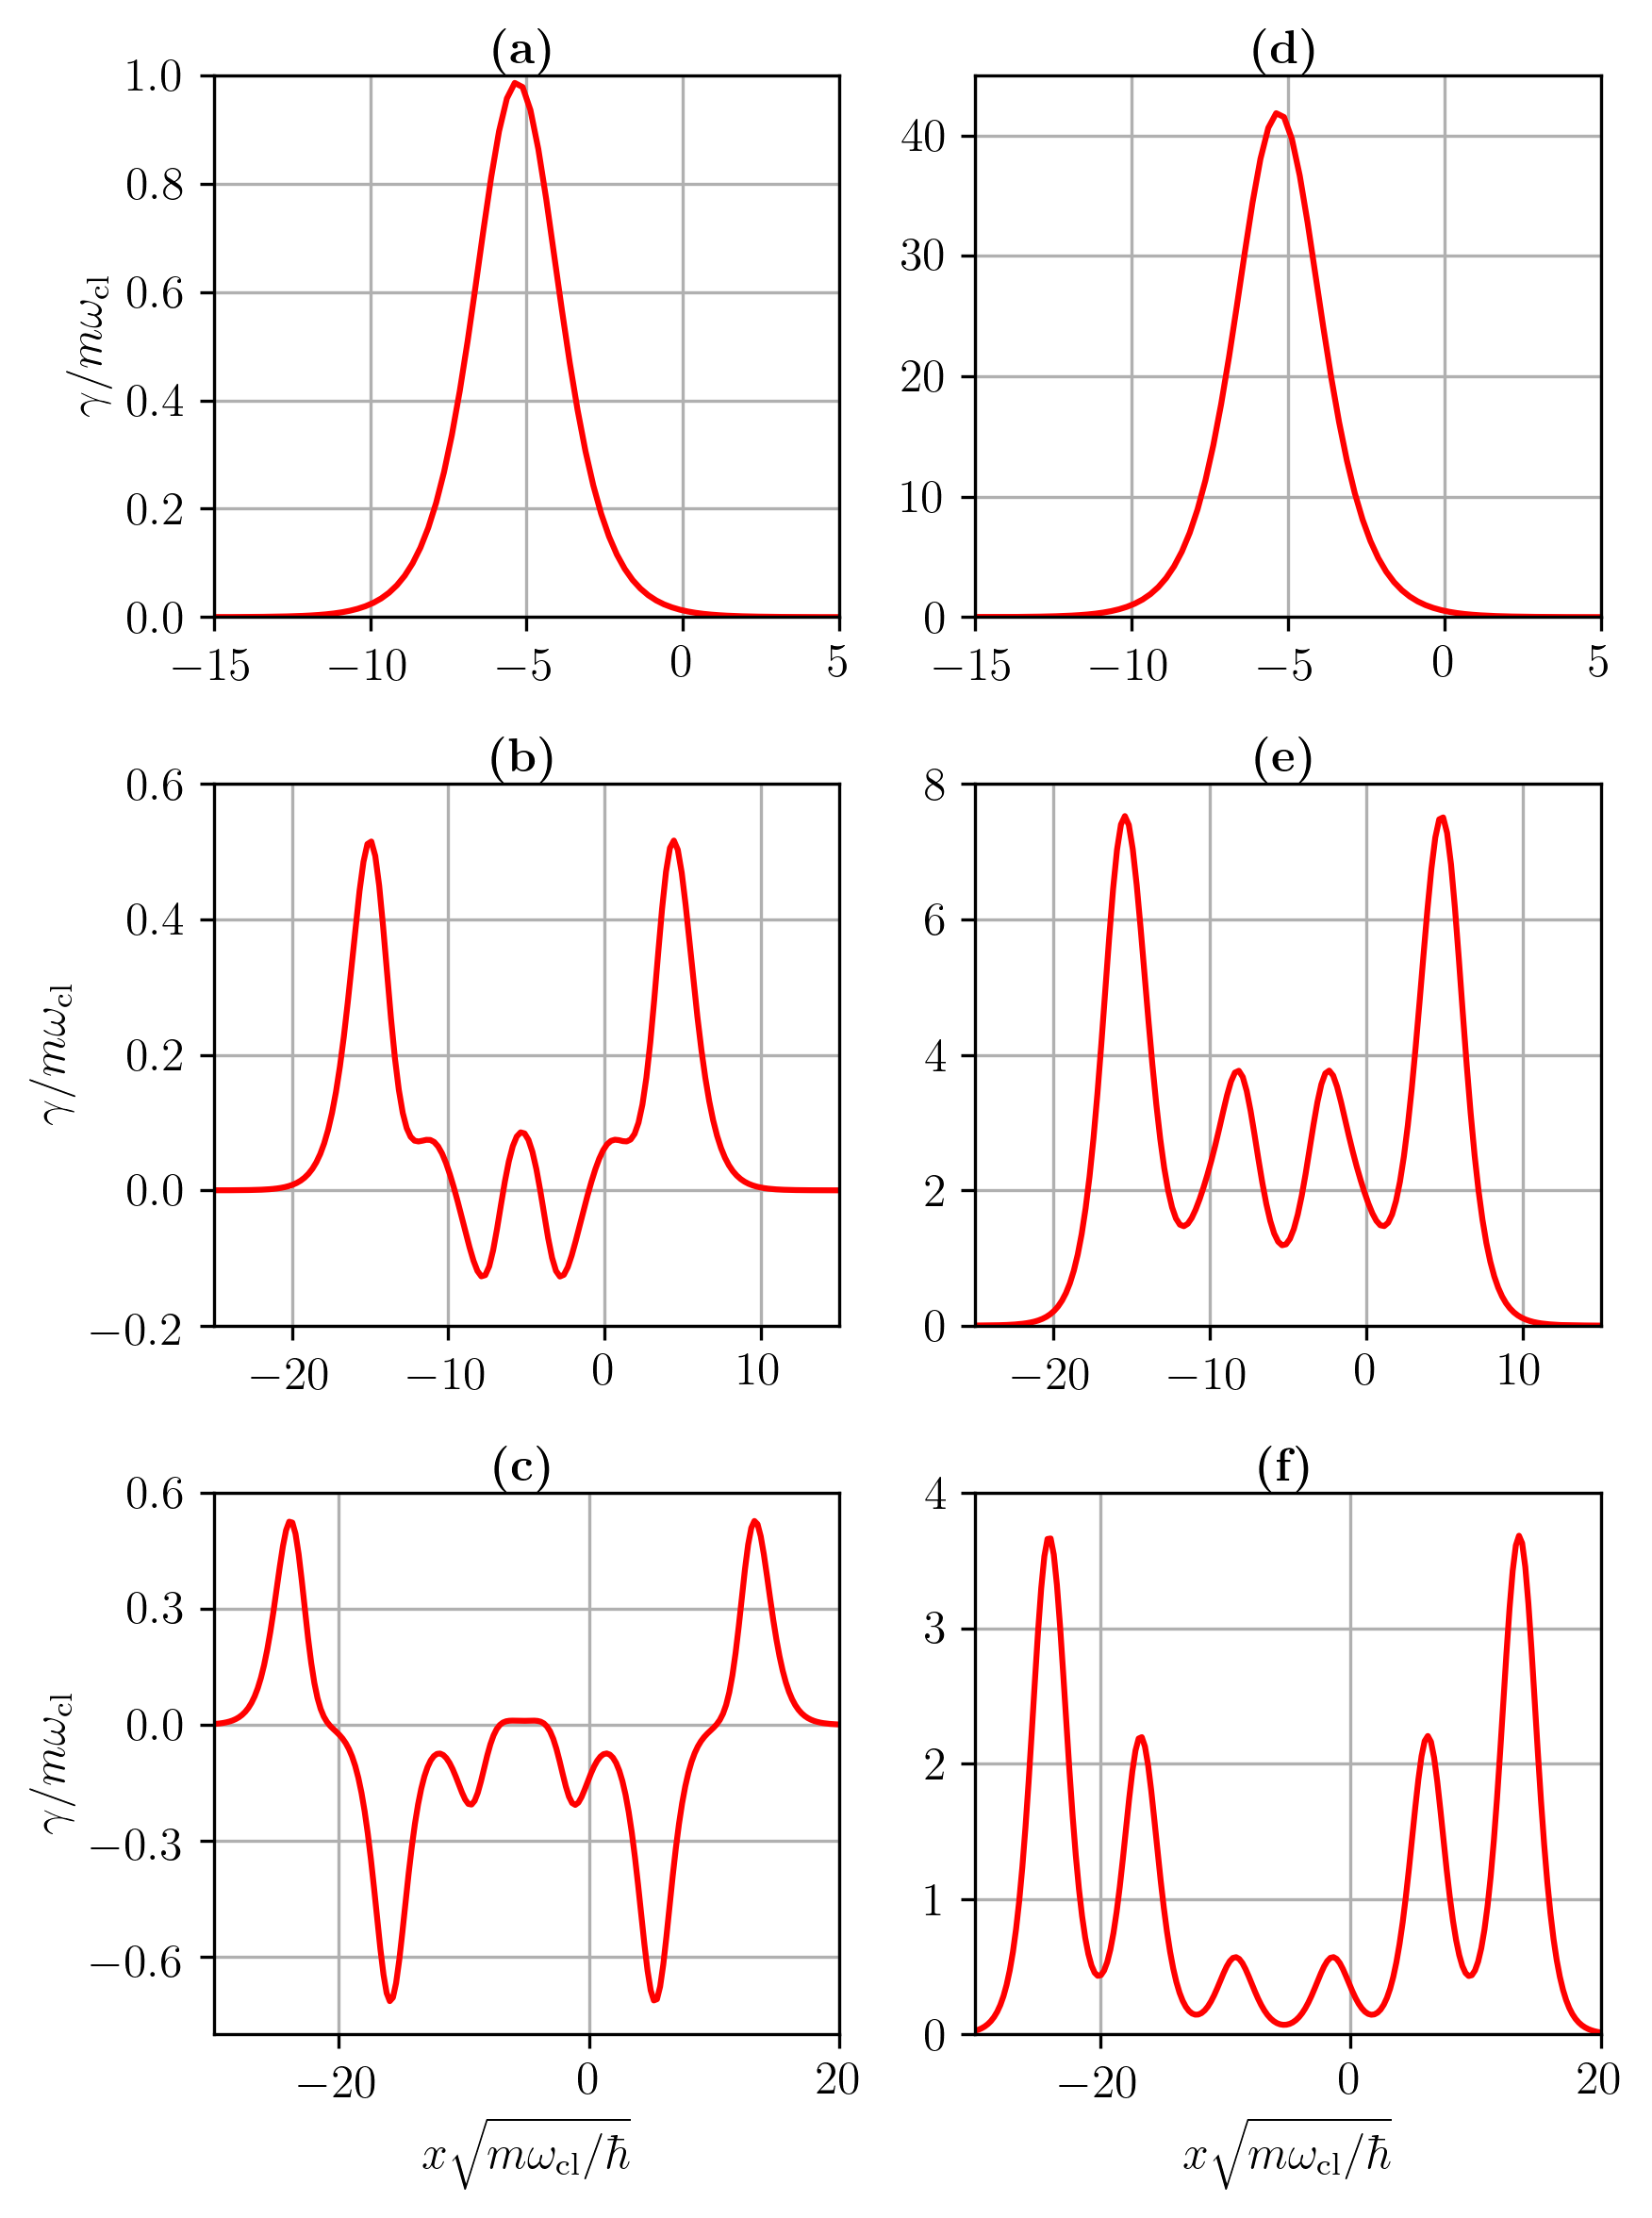

In [10]:
fig, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = pyplot.subplots(3, 2, figsize=(6, 8), tight_layout=True)

friction1 = numpy.loadtxt("data/holstein/friction_0.1_voltage_0.0-25")
friction2 = numpy.loadtxt("data/holstein/friction_0.1_voltage_0.5-25")
friction3 = numpy.loadtxt("data/holstein/friction_0.1_voltage_1.0-25")
friction4 = numpy.loadtxt("data/holstein/friction_0.4_voltage_0.0-25")
friction5 = numpy.loadtxt("data/holstein/friction_0.4_voltage_0.5-25")
friction6 = numpy.loadtxt("data/holstein/friction_0.4_voltage_1.0-25")

ax1.plot(friction1[0], bmme._hbar * friction1[1], c="red")
#ax1.set_xlabel("$x\\sqrt{m\\omega_\\mathrm{cl}/\\hbar}$")
ax1.set_ylabel("$\\gamma/m\\omega_\\mathrm{cl}$")
ax1.set_xlim(-15, 5)
#ax1.set_xticks([-10, -5, 0, 5, 10])
ax1.set_ylim(.0, 1.)
#ax1.set_yticks([.0, .1, .2, .3, .4, .5])
ax1.grid()
ax1.text(-5., 1., "\\textbf{(a)}", ha="center", va="bottom")

ax2.plot(friction2[0], bmme._hbar * friction2[1], c="red")
#ax2.set_xlabel("$x\\sqrt{m\\omega_\\mathrm{cl}/\\hbar}$")
ax2.set_ylabel("$\\gamma/m\\omega_\\mathrm{cl}$")
ax2.set_xlim(-25, 15)
#ax2.set_xticks([-10, -5, 0, 5, 10])
ax2.set_ylim(-.2, .6)
#ax2.set_yticks([.0, .1, .2, .3, .4, .5])
ax2.grid()
ax2.text(-5., .6, "\\textbf{(b)}", ha="center", va="bottom")

ax3.plot(friction3[0], bmme._hbar * friction3[1], c="red")
ax3.set_xlabel("$x\\sqrt{m\\omega_\\mathrm{cl}/\\hbar}$")
ax3.set_ylabel("$\\gamma/m\\omega_\\mathrm{cl}$")
ax3.set_xlim(-30, 20)
#ax3.set_xticks([-10, -5, 0, 5, 10])
ax3.set_ylim(-.8, .6)
ax3.set_yticks([-.6, -.3, .0, .3, .6])
ax3.grid()
ax3.text(-5., .6, "\\textbf{(c)}", ha="center", va="bottom")

ax4.plot(friction4[0], bmme._hbar * friction4[1], c="red")
#ax4.set_xlabel("$x\\sqrt{m\\omega_\\mathrm{cl}/\\hbar}$")
#ax4.set_ylabel("$\\gamma/m\\omega_\\mathrm{cl}$")
ax4.set_xlim(-15, 5)
#ax4.set_xticks([-10, -5, 0, 5, 10])
ax4.set_ylim(.0, 45.)
#ax4.set_yticks([.0, .1, .2, .3, .4, .5])
ax4.grid()
ax4.text(-5., 45., "\\textbf{(d)}", ha="center", va="bottom")

ax5.plot(friction5[0], bmme._hbar * friction5[1], c="red")
#ax5.set_xlabel("$x\\sqrt{m\\omega_\\mathrm{cl}/\\hbar}$")
#ax5.set_ylabel("$\\gamma/m\\omega_\\mathrm{cl}$")
ax5.set_xlim(-25, 15)
#ax5.set_xticks([-10, -5, 0, 5, 10])
ax5.set_ylim(.0, 8.)
#ax5.set_yticks([.0, .1, .2, .3, .4, .5])
ax5.grid()
ax5.text(-5., 8., "\\textbf{(e)}", ha="center", va="bottom")

ax6.plot(friction6[0], bmme._hbar * friction6[1], c="red")
ax6.set_xlabel("$x\\sqrt{m\\omega_\\mathrm{cl}/\\hbar}$")
#ax6.set_ylabel("$\\gamma/m\\omega_\\mathrm{cl}$")
ax6.set_xlim(-30, 20)
#ax6.set_xticks([-10, -5, 0, 5, 10])
ax6.set_ylim(.0, 4.)
#ax6.set_yticks([.0, .1, .2, .3, .4, .5])
ax6.grid()
ax6.text(-5., 4., "\\textbf{(f)}", ha="center", va="bottom")

pyplot.savefig("holstein_cl1.pdf")
pyplot.gcf().set_dpi(300)
pyplot.show()